<a href="https://colab.research.google.com/github/neelabhro/DRL-based-Wireless-Communications/blob/main/expeca_AWGN_Single_Layered(No_Activation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands On - Simple Autoencoder Communication System Example
## In this notebook we show how to implement an autoencoder communication system in tensorflow

By Sebastian Cammerer and Sebastian D&ouml;rner.  
Contact [cammerer@inue.uni-stuttgart.de](mailto:cammerer@inue.uni-stuttgart.de), [doerner@inue.uni-stuttgart.de](mailto:doerner@inue.uni-stuttgart.de)

This code is provided as supplementary material to the ETI blog article [LINK TBD](TBD).
It is licensed under the GPLv2 license. If you in any way use this code for research that results in publications, please cite it appropriately.

At first we need to import the required libraries: tensorflow, to perform computing graph based training of the NN; numpy, for basic computations and to feed the NN; matplotlib, to plot our results.

In [63]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt

Then we need to define the main parameters of the autoencoder, k and n.

In [64]:
k = 8          # Number of information bits per message, i.e., M=2**k
n = 8          # Number of real channel uses per message
M=2**k         # Number of messages
j = np.complex(0,1) #create complex number

Now we start building our model in tensorflow. For this simple example, we define all variables in the tensorflow default graph. We begin with one of the most basic parameters in DL, the batch_size. This defines the amount of samples within a mini-batch that is used for stochastic gradient computation. In our case we want this to be a flexible amount to later, during training, be able to adjust this to get more accurate gradients. Therefore, and given the fact that we can generate as many samples as we want on the fly, we define the batch_size as a feedable scalar integer.

Now we can create the messages we want to transmit in this batch. They are simple drawn from a random uniform distribution.

And to efficiently feed them to the first dense NN layer of the transmitter part, we transform them to so called one-hot vectors.

In [65]:
# AUTOENCODER SYSTEM MODEL
batch_size = tf.placeholder(tf.int32,shape=[])
s = tf.random.uniform(shape=[batch_size],minval=0,maxval=M,dtype=tf.int32)
s_one_hot = tf.one_hot(s,depth=M)
#s_one_hot = tf.cast(s_one_hot, tf.complex64)

This tensor now holds batch_size vectors of length M, where only one entry is set to 1.0 while all other entries are 0.0.
Let’s define the transmitter part. Only two dense layers are already enough to perform a transformation from messages to real valued channel uses. This is basically a simple lookup-table transformation that could also be implemented by a single matrix of trainable weights, but for simplicity reasons we use default tensorflow/keras dense layers in the following. The first dense transmitter layer shall be “relu” activated and can have any number of units, we chose M because the samples of input s_one_hot are also of length M. The second dense layer is required to have n units, which form the output of the transmitter, and shall not have any activation function, since we want the transmitter to be able to output any real valued numbers.

To prevent the transmitter from learning unnecessarily large outputs and becoming numerically instable, we normalize the average power of all transmitter outputs in the mini-batch to equal 1.0.

In [66]:
# Transmitter
#tx = tf.keras.layers.Dense(units=M,activation="relu")(s_one_hot)
tx = tf.keras.layers.Dense(units=n,activation=None)(s_one_hot)
x = tx / tf.sqrt(tf.reduce_mean(tf.square(tx)))
#x = tf.cast(x, tf.complex64)
tf.size(tx)

<tf.Tensor 'Size_4:0' shape=() dtype=int32>

Now x is the output of our transmitter, next comes the channel. We chose a basic additive white Gaussian noise (AWGN) channel that simply adds scaled normal distributed real values on top of x. But to be able to adaptively change the noise power and thereby the signal to noise ratio (SNR), we implement the noise standard deviation as a feedable tensorflow placeholder.

Then we simply draw a noise tensor of the same shape as x from a normal distribution with the standard deviation given by the placeholder.

Now we simply add this random noise tensor on top of x to get y, which are the received messages.

In [67]:
# Channel
noise_std = tf.placeholder(dtype=tf.float32,shape=[])
noise = tf.random.normal(shape=tf.shape(x),stddev=noise_std)
#noise = tf.cast(noise, tf.complex64)

real_fade = tf.random.normal(shape=tf.shape(x))
complex_fade = tf.random.normal(shape=tf.shape(x))
fade = tf.complex(real_fade, complex_fade)
fade = tf.math.abs(fade)
fade = tf.math.sqrt(1/2)*fade
y = x + noise


#noise_std = tf.placeholder(dtype=tf.float32,shape=[])
#noise = tf.random.normal(shape=tf.shape(x),stddev=noise_std)
#real_fade = tf.random.normal(shape=tf.shape(x))
#complex_fade = tf.random.normal(shape=tf.shape(x))
#fade = tf.complex(real_fade, complex_fade)
#fade = np.sqrt(1/2)*fade
#y = x*fade + noise


With the channel being the penalty layer of our autoencoder, we now need a receiver part that produces a reproduction s_hat given y. This receiver part consists of a first dense layer that can have an arbitrary amount of units, we chose M, and is required to have a non-linear activation, we chose “relu”.

Depending on the complexity of the channel model we could now add several of those layers to our model to increase the complexity and capabilities of the neural network. But for the simple AWGN channel, one input and one output layer is enough at receiver side. The dense output layer is required to have M units, since we want to produce a prediction on the probability of each possible message, and the output shall be so called “logits”, which means that no activation function is needed.

In [68]:
# Receiver
#y = tf.cast(x, tf.float32)
#rx = tf.keras.layers.Dense(units=M, activation="relu")(y)
#s_hat = tf.keras.layers.Dense(units=M, activation="relu")(y)
s_hat = tf.keras.layers.Dense(units=M, activation=None)(y)

Now the autoencoder is fully described, we can feed in messages and get predictions as an output. What is still missing is a loss function that calculates the current performance of the model by comparing the input s with the output s_hat. We use a default cross entropy loss function that inherently activates the logits with “softmax” and accepts sparse labels.

In [69]:
# Loss function
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s,logits=s_hat)

We also calculate the average message (or block) error rate of the mini-batch by hard-deciding the receiver’s output on the element with the highest probability (argmax).

In [70]:
# Metrics
correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat),axis=1,output_type=tf.int32),s)
accuracy = tf.reduce_mean(tf.cast(correct_predictions,dtype=tf.float32))
bler = 1.0 - accuracy

Finally, we need to define an optimizer algorithm that updates the weights of our autoencoder according to the current loss and the gradient of the batch. We chose the Adam optimizer to minimize our loss function and use a placeholder as learning rate to be able to adjust this hyperparameter during training.

In [71]:
# Optimizer
lr = tf.placeholder(dtype=tf.float32,shape=[])
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cross_entropy)

Now that the tensorflow graph is defined, we need to create a tensorflow session that can run the graph.

After creating the session all trainable variables need to be initialized. Since the used tensorflow/keras layers already define functions to create their initial weights, we simply need to run the global variables initializer and all weights are ready to go.

In [72]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Before we start with the training, we need to formulate an SNR definition, so that we can easily train at a desired SNR point. This function simply calculates the noise standard deviation for a given SNR (while signal power is normalized to 1.0).

In [73]:
def EbNo2Sigma(ebnodb):
  '''Convert Eb/No in dB to noise standard deviation'''
  ebno = 10**(ebnodb/10)
  bits_per_complex_symbol = k/(n/2)
  return 1.0/np.sqrt(bits_per_complex_symbol*ebno)

Now we can begin with the training. We start with 1,000 iterations of running the train_op function with a small batch_size of only 100 messages and a learning rate of 0.001. After this first training epoch we reduce the learning rate to 0.0001 and run another epoch with 10,000 iterations. For the last training epoch we raise the batch size to 1,000 and run another 10,000 iterations. During all training epochs we set the SNR to 7.0 dB as we figured that training the autoencoder at a BLER of around 0.01 leads to a fast generalization.

In [74]:
for i in range(1000):
  sess.run(train_op, feed_dict={batch_size: 100, noise_std: EbNo2Sigma(7.0), lr: 0.001})

for i in range(10000):
  sess.run(train_op, feed_dict={batch_size: 100, noise_std: EbNo2Sigma(7.0), lr: 0.0001})

for i in range(10000):
  sess.run(train_op, feed_dict={batch_size: 1000, noise_std: EbNo2Sigma(7.0), lr: 0.0001})

So, let’s check the performance of the autoencoder by plotting its BLER vs SNR over a range of SNR. Therefore, we need to run a Monte Carlo simulation to get an accurate BLER for each SNR point. In this example we simulate the BLER from 0 to 14dB by running 10 mini-batches of 100,000 messages for each SNR point.

In [75]:
snr_range = np.linspace(0,14,15)
monte_carlo_bler = np.zeros((len(snr_range),))
for i in range(len(snr_range)):
  for j in range(10):
    monte_carlo_bler[i] += sess.run(bler, feed_dict={batch_size: 100000, noise_std: EbNo2Sigma(snr_range[i]), lr: 0.0})
monte_carlo_bler = monte_carlo_bler / 10

Finally, we plot the BLER vs SNR using matplotlib.

(1e-05, 1)

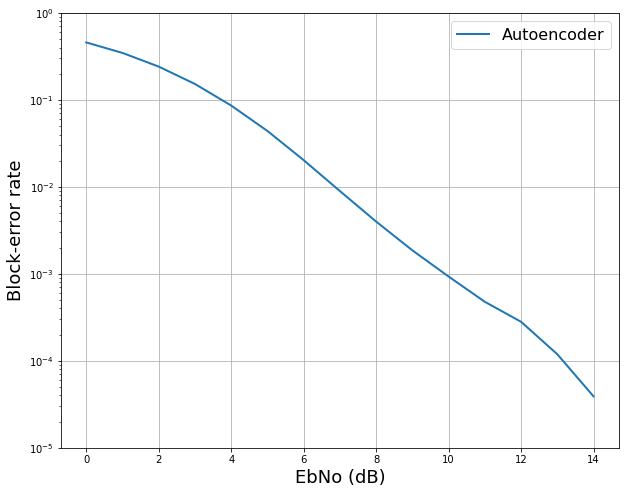

In [76]:
plt.figure(figsize=(10,8))
plt.plot(snr_range, monte_carlo_bler, linewidth=2.0)
plt.legend(['Autoencoder'], prop={'size': 16}, loc='upper right');
plt.yscale('log')
plt.xlabel('EbNo (dB)', fontsize=18)
plt.ylabel('Block-error rate', fontsize=18)
plt.grid(True)
plt.ylim([1e-5,1])

One could now compare this performance with other modulation schemes. In the example linked colabolatory example we also provide the uncoded BLER of the quadrature phase shift keying (QPSK) modulation scheme.

(1e-05, 1)

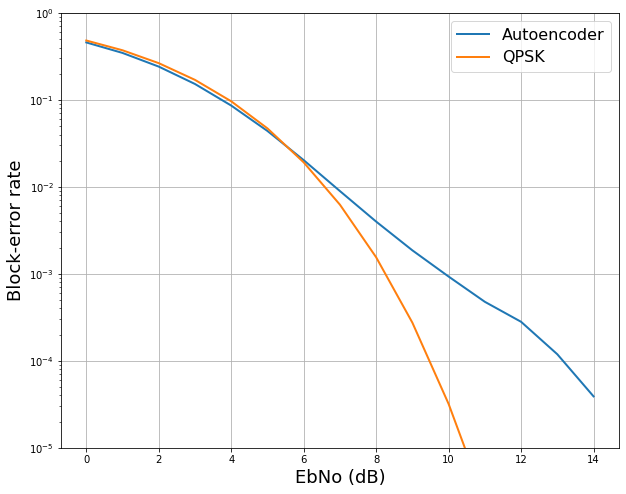

In [77]:
BLER_QPSK_k8n8 = np.array([4.818329E-01, 3.720104E-01, 2.645386E-01, 1.698987E-01, 9.636992E-02, 4.703772E-02, 1.914436E-02, 6.244719E-03, 1.551032E-03, 2.745986E-04, 3.194809E-05, 2.384186E-06, 0.000000E+00, 0.000000E+00, 0.000000E+00])

plt.figure(figsize=(10,8))
plt.plot(snr_range, monte_carlo_bler, linewidth=2.0)
plt.plot(snr_range, BLER_QPSK_k8n8, linewidth=2.0)
plt.legend(['Autoencoder', 'QPSK'], prop={'size': 16}, loc='upper right');
plt.yscale('log')
plt.xlabel('EbNo (dB)', fontsize=18)
plt.ylabel('Block-error rate', fontsize=18)
plt.grid(True)
plt.ylim([1e-5,1])